# Whisper Probability Trace Analysis
This notebook demonstrates how to extract and visualize the "Probability Trace" of a target word from the OpenAI Whisper model.

The procedure involves:
1. Loading the Whisper model.
2. Forcing the model to align a specific target word (or competitor) to the audio.
3. Extracting the **Cross-Attention** weights from the valid decoder steps.
4. Weighting the attention by the predicted **Token Probabilities**.
5. Computing a time-series "Trace" that approximates when the word is being spoken and with what confidence.


In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import seaborn as sns
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [6]:
# Load Model and Processor
model_name = "openai/whisper-base"
print(f"Loading {model_name}...")

processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name, attn_implementation="eager").to(device)
model.eval()
print("Model loaded.")


Loading openai/whisper-base...
Model loaded.


In [7]:
def load_audio(path):
    """Loads audio and resamples to 16kHz."""
    waveform, sample_rate = torchaudio.load(path)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    return waveform.squeeze()

def get_whisper_trace_with_details(audio_features, target_word, processor, model, waveform_len_sec=None):
    """
    Computes the probability trace and returns intermediate details for visualization.
    """
    target_text = target_word.lower()
    
    # --- 1. Construct Decoder Input Sequences ---
    # Start of Transcript + Language + Task tokens
    sot_token = processor.tokenizer.convert_tokens_to_ids("<|startoftranscript|>")
    
    # Get forced decoder ids (Language=en, Task=transcribe, No Timestamps)
    try:
        forced_decoder_ids = processor.tokenizer.get_decoder_prompt_ids(language="en", task="transcribe", no_timestamps=True)
    except AttributeError:
        forced_decoder_ids = processor.get_decoder_prompt_ids(language="en", task="transcribe", no_timestamps=True)
    
    prefix_tokens = [sot_token]
    if forced_decoder_ids:
        forced_decoder_ids.sort(key=lambda x: x[0])
        for idx, token in forced_decoder_ids:
            prefix_tokens.append(token)
            
    # Target Tokenization
    text_tokens = processor.tokenizer.encode(target_text, add_special_tokens=False)
    eot_token = processor.tokenizer.eos_token_id
    
    # Full Sequence: [SOT, ..., WordTokens, EOT]
    full_sequence = prefix_tokens + text_tokens + [eot_token]
    print([processor.tokenizer.convert_ids_to_tokens([token])[0] for token in full_sequence])
    decoder_input_ids = torch.tensor([full_sequence], dtype=torch.long, device=device)
    
    # --- 2. Forward Pass ---
    with torch.no_grad():
        outputs = model(
            input_features=audio_features,
            decoder_input_ids=decoder_input_ids,
            output_attentions=True,
            return_dict=True
        )
    
    # --- 3. Extract Probabilities (Logits) ---
    logits = outputs.logits # (1, SeqLen, V)
    probs = F.softmax(logits, dim=-1)
    
    # Identify the specific tokens we care about (The word itself)
    # The decoder_input_ids are [SOT, ... P1, P2, ... T1, T2 ... EOT]
    # Logits at index `i` predict the token at `i+1`.
    
    # We want the probabilities of T1...Tn
    # These tokens are at indices `len(prefix_tokens)` to `len(prefix_tokens)+len(text_tokens)` in `full_sequence`.
    start_idx = len(prefix_tokens)
    end_idx = start_idx + len(text_tokens)
    
    # The logits that predict T1 are at index `start_idx - 1` (the step before T1).
    # But wait, let's keep it simple: 
    # We want to check P(Token_i) given previous.
    
    token_probs = []
    target_ids = decoder_input_ids[0, 1:] # The actual targets shifted
    
    # Collect probs for the word tokens only
    # The indices in `target_ids` for our word are: `start_idx-1` to `end_idx-1`
    word_indices_in_target = range(start_idx-1, end_idx-1)
    print("len of probs:", probs.shape)
    print("Word Indexs in Target:", list(word_indices_in_target))
    for i in word_indices_in_target:
        true_token_id = target_ids[i]
        p = probs[0, i, true_token_id].item()
        token_probs.append(p)
        current_token = processor.tokenizer.convert_ids_to_tokens([true_token_id])[0]
        previous_tokens = processor.tokenizer.convert_ids_to_tokens(decoder_input_ids[0, :i+1].tolist()) # +1 for target shift
        print("P({}|{}) = {p:.4f}".format(current_token, previous_tokens, p=p))
        
    token_probs_tensor = torch.tensor(token_probs, device=device)
    
    # --- 4. Extract Attention ---
    # Last layer cross-attention: (Batch, Heads, DecoderSeq, EncoderSeq)
    layer_atten = outputs.cross_attentions[-1] 
    avg_atten = layer_atten.mean(dim=1).squeeze(0) # (DecoderSeq, EncoderSeq)
    
    # Crop Attention to Actual Audio Length
    # Whisper encoder outputs 1500 frames for 30s audio.
    # 30s / 1500 frames = 0.02s (20ms) per frame.
    if waveform_len_sec is not None:
        num_frames = int(waveform_len_sec / 0.02)
        # Ensure we don't go out of bounds if calculation is slightly off
        num_frames = min(num_frames, avg_atten.shape[1])
        avg_atten = avg_atten[:, :num_frames]

    # Review alignment:
    # DecoderSeq matches `decoder_input_ids`.
    # Attention at index `i` is used to generate `logits[i]`.
    # We established that `logits[i]` predicts `decoder_input_ids[i+1]`.
    # So `avg_atten[i]` is the map used to predict token `i+1`.
    
    # We want the attention maps responsible for predicting T1...Tn.
    # These map indices are `start_idx-1` to `end_idx-1`.
    
    word_attentions = avg_atten[start_idx-1 : end_idx-1, :] # (NumWordTokens, EncoderFrames)

    # --- 5. Compute Trace ---
    # Weighted Sum Logic
    weighted_atts = word_attentions * token_probs_tensor.unsqueeze(1)
    raw_trace = weighted_atts.mean(dim=0).cpu().numpy()
    
    # Scaling
    max_val = raw_trace.max()
    mean_prob = token_probs_tensor.mean().item()
    
    if max_val > 0:
        scaled_trace = raw_trace / max_val * mean_prob
    else:
        scaled_trace = raw_trace

    return {
        "trace": scaled_trace,
        "raw_attentions": word_attentions.cpu().numpy(),
        "token_probs": token_probs,
        "tokens": processor.tokenizer.convert_ids_to_tokens(text_tokens),
        "full_attention_matrix": avg_atten.cpu().numpy()
    }

In [8]:
# Select an Audio File
wav_path = "dataset/en/ainhoa/academy.wav"
target_word = "academy"

print(f"Processing: {wav_path}")
print(f"Target Word: {target_word}")

# Prepare Audio
waveform = load_audio(wav_path)

# Pad with 200ms silence (optional, as in your script)
silence = torch.zeros(int(0.2 * 16000))
waveform = torch.cat([silence, waveform], dim=0)

duration_sec = waveform.shape[0] / 16000
print(f"Audio Duration: {duration_sec:.2f}s")

input_features = processor(waveform, sampling_rate=16000, return_tensors="pt").input_features.to(device)

# Run Analysis with cropping
result = get_whisper_trace_with_details(input_features, target_word, processor, model, waveform_len_sec=duration_sec)

trace = result["trace"]
attentions = result["raw_attentions"]
token_probs = result["token_probs"]
tokens = result["tokens"]

print(f"Token Probabilities: {token_probs}")
print(f"Tokens: {tokens}")
print(f"Trace Shape: {trace.shape} (Should correspond to approx {duration_sec/0.02:.0f} frames)")

Processing: dataset/en/ainhoa/academy.wav
Target Word: academy
Audio Duration: 0.90s
['<|startoftranscript|>', '<|en|>', '<|transcribe|>', '<|notimestamps|>', 'ac', 'ad', 'emy', '<|endoftext|>']
len of probs: torch.Size([1, 8, 51865])
Word Indexs in Target: [3, 4, 5]
P(ac|['<|startoftranscript|>', '<|en|>', '<|transcribe|>', '<|notimestamps|>']) = 0.0000
P(ad|['<|startoftranscript|>', '<|en|>', '<|transcribe|>', '<|notimestamps|>', 'ac']) = 0.9621
P(emy|['<|startoftranscript|>', '<|en|>', '<|transcribe|>', '<|notimestamps|>', 'ac', 'ad']) = 0.9363
Token Probabilities: [9.343532838101964e-06, 0.9621210098266602, 0.9362603425979614]
Tokens: ['ac', 'ad', 'emy']
Trace Shape: (44,) (Should correspond to approx 45 frames)


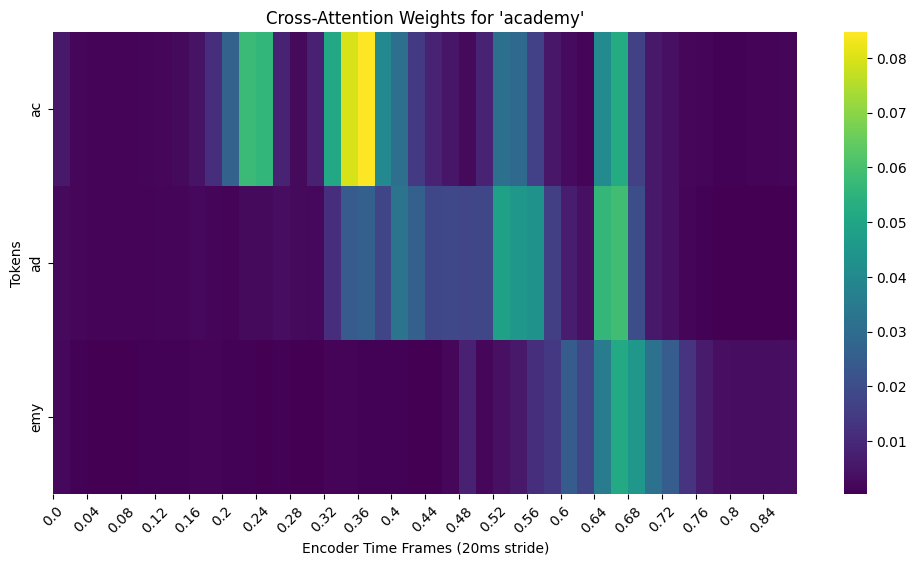

In [14]:
# --- Visualization 1: Cross-Attention Heatmap ---
plt.figure(figsize=(12, 6))
# We just plot the attention for the word tokens
sns.heatmap(attentions, xticklabels=50, yticklabels=tokens, cmap="viridis")
# add x-axis labels every 50 frames (1s intervals)
num_frames = attentions.shape[1]
xticks = np.arange(0, num_frames, 2)
plt.xticks(xticks, [f"{(x*0.02)}" for x in xticks], rotation=45)
plt.title(f"Cross-Attention Weights for '{target_word}'")
plt.xlabel("Encoder Time Frames (20ms stride)")
plt.ylabel("Tokens")
plt.show()


waveform.shape: torch.Size([14322]) Duration (s): 0.895125
trace.shape: (44,)


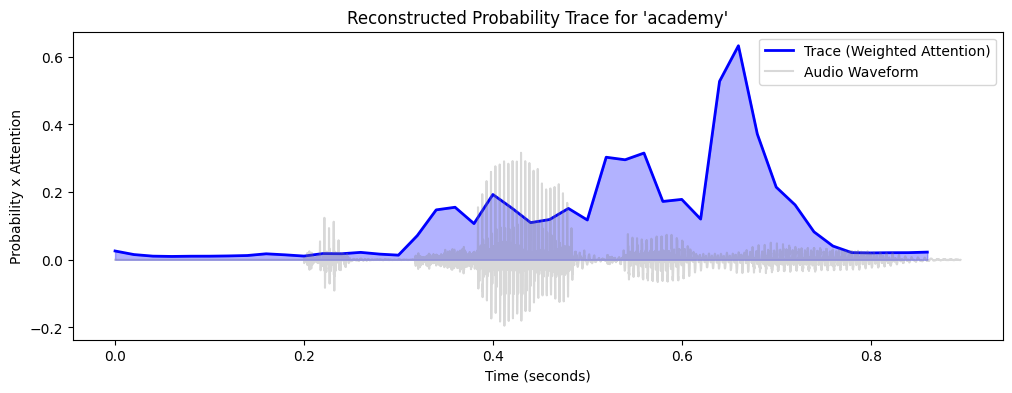

In [10]:
# --- Visualization 2: Probability Trace ---
plt.figure(figsize=(12, 4))
time_axis = np.arange(len(trace)) * 0.02 # 20ms per frame
plt.plot(time_axis, trace, label="Trace (Weighted Attention)", color='blue', linewidth=2)
plt.fill_between(time_axis, trace, alpha=0.3, color='blue')

print("waveform.shape:", waveform.shape, "Duration (s):", len(waveform)/16000)
print("trace.shape:", trace.shape)
# Overlay waveform for context
# Normalize waveform to fit in plot
if hasattr(waveform, 'cpu'):
    wave_norm = waveform.cpu().numpy()
else:
    wave_norm = waveform

# Ensure it's flattened if needed (though usually waveform is 1D or (1, N))
if len(wave_norm.shape) > 1:
     wave_norm = wave_norm.flatten()

wave_norm = wave_norm / np.max(np.abs(wave_norm)) * np.max(trace) * 0.5
wave_time = np.linspace(0, len(wave_norm)/16000, len(wave_norm))

plt.plot(wave_time, wave_norm, color='gray', alpha=0.3, label="Audio Waveform")

plt.title(f"Reconstructed Probability Trace for '{target_word}'")
plt.xlabel("Time (seconds)")
plt.ylabel("Probability x Attention")
plt.legend()
plt.show()

In [16]:
import pandas as pd
from io import StringIO

# CSV data as string
csv_data = """CSE,StartTime,EndTime
0.00461509743038356,0.0160625,0.0480625
0.00398167099526158,0.0480625,0.0800625
0.000402492535974088,0.0800625,0.1120625
0.00114149367141236,0.1120625,0.1440625
0.00119114994965916,0.1440625,0.1760625
0.0108513169099266,0.1760625,0.2080625
0.0134109197298982,0.2080625,0.2400625
0.0081368354424505,0.2400625,0.2720625
0.0129680979495652,0.2720625,0.3040625
0.00287310018786057,0.3040625,0.3360625
0.00576959994454725,0.3360625,0.3680625
0.00139835964114842,0.3680625,0.4000625
0.00783668570507298,0.4000625,0.4320625
0.0064889992798123,0.4320625,0.4640625
0.00537744225327909,0.4640625,0.4960625
0.0023447629977808,0.4960625,0.5280625
0.003723536658874,0.5280625,0.5600625
0.00353341078686435,0.5600625,0.5920625
0.00129099822496311,0.5920625,0.6240625
0.00322298610110645,0.6240625,0.6560625
0.00117900042730283,0.6560625,0.6880625"""

# Convert to DataFrame
df = pd.read_csv(StringIO(csv_data))
print(df)

         CSE  StartTime   EndTime
0   0.004615   0.016063  0.048063
1   0.003982   0.048063  0.080062
2   0.000402   0.080062  0.112062
3   0.001141   0.112062  0.144063
4   0.001191   0.144063  0.176063
5   0.010851   0.176063  0.208063
6   0.013411   0.208063  0.240063
7   0.008137   0.240063  0.272062
8   0.012968   0.272062  0.304063
9   0.002873   0.304063  0.336062
10  0.005770   0.336062  0.368063
11  0.001398   0.368063  0.400062
12  0.007837   0.400062  0.432063
13  0.006489   0.432063  0.464062
14  0.005377   0.464062  0.496063
15  0.002345   0.496063  0.528062
16  0.003724   0.528062  0.560063
17  0.003533   0.560063  0.592063
18  0.001291   0.592063  0.624062
19  0.003223   0.624062  0.656062
20  0.001179   0.656062  0.688063


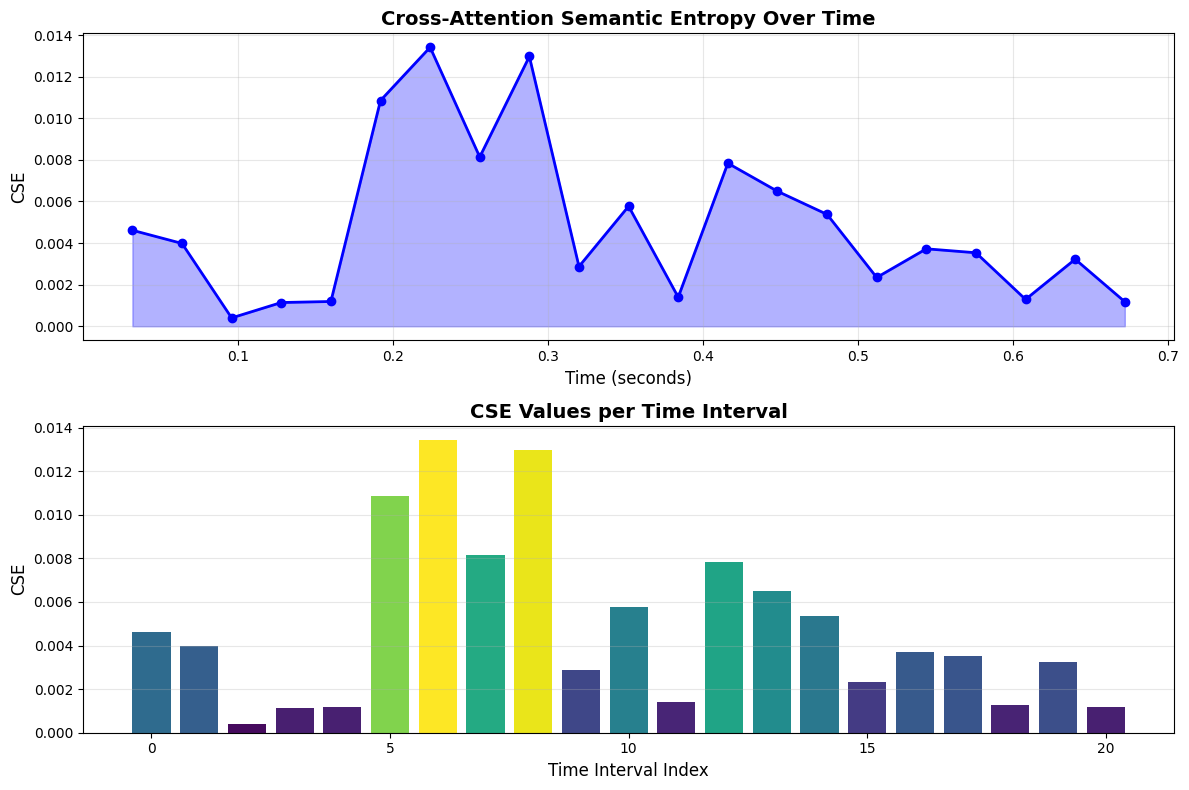


DataFrame Statistics:
             CSE  StartTime    EndTime
count  21.000000  21.000000  21.000000
mean    0.004845   0.336062   0.368063
std     0.003875   0.198555   0.198555
min     0.000402   0.016063   0.048063
25%     0.001398   0.176063   0.208063
50%     0.003724   0.336062   0.368063
75%     0.006489   0.496063   0.528062
max     0.013411   0.656062   0.688063


In [17]:
# Plot the data
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: CSE over time intervals
ax1 = axes[0]
midpoint = (df['StartTime'] + df['EndTime']) / 2
ax1.plot(midpoint, df['CSE'], marker='o', linewidth=2, markersize=6, color='blue')
ax1.fill_between(midpoint, df['CSE'], alpha=0.3, color='blue')
ax1.set_xlabel('Time (seconds)', fontsize=12)
ax1.set_ylabel('CSE', fontsize=12)
ax1.set_title('Cross-Attention Semantic Entropy Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Time intervals as bars
ax2 = axes[1]
intervals = [f"{s:.2f}-{e:.2f}" for s, e in zip(df['StartTime'], df['EndTime'])]
colors = plt.cm.viridis(df['CSE'] / df['CSE'].max())
ax2.bar(range(len(df)), df['CSE'], color=colors)
ax2.set_xlabel('Time Interval Index', fontsize=12)
ax2.set_ylabel('CSE', fontsize=12)
ax2.set_title('CSE Values per Time Interval', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nDataFrame Statistics:")
print(df.describe())

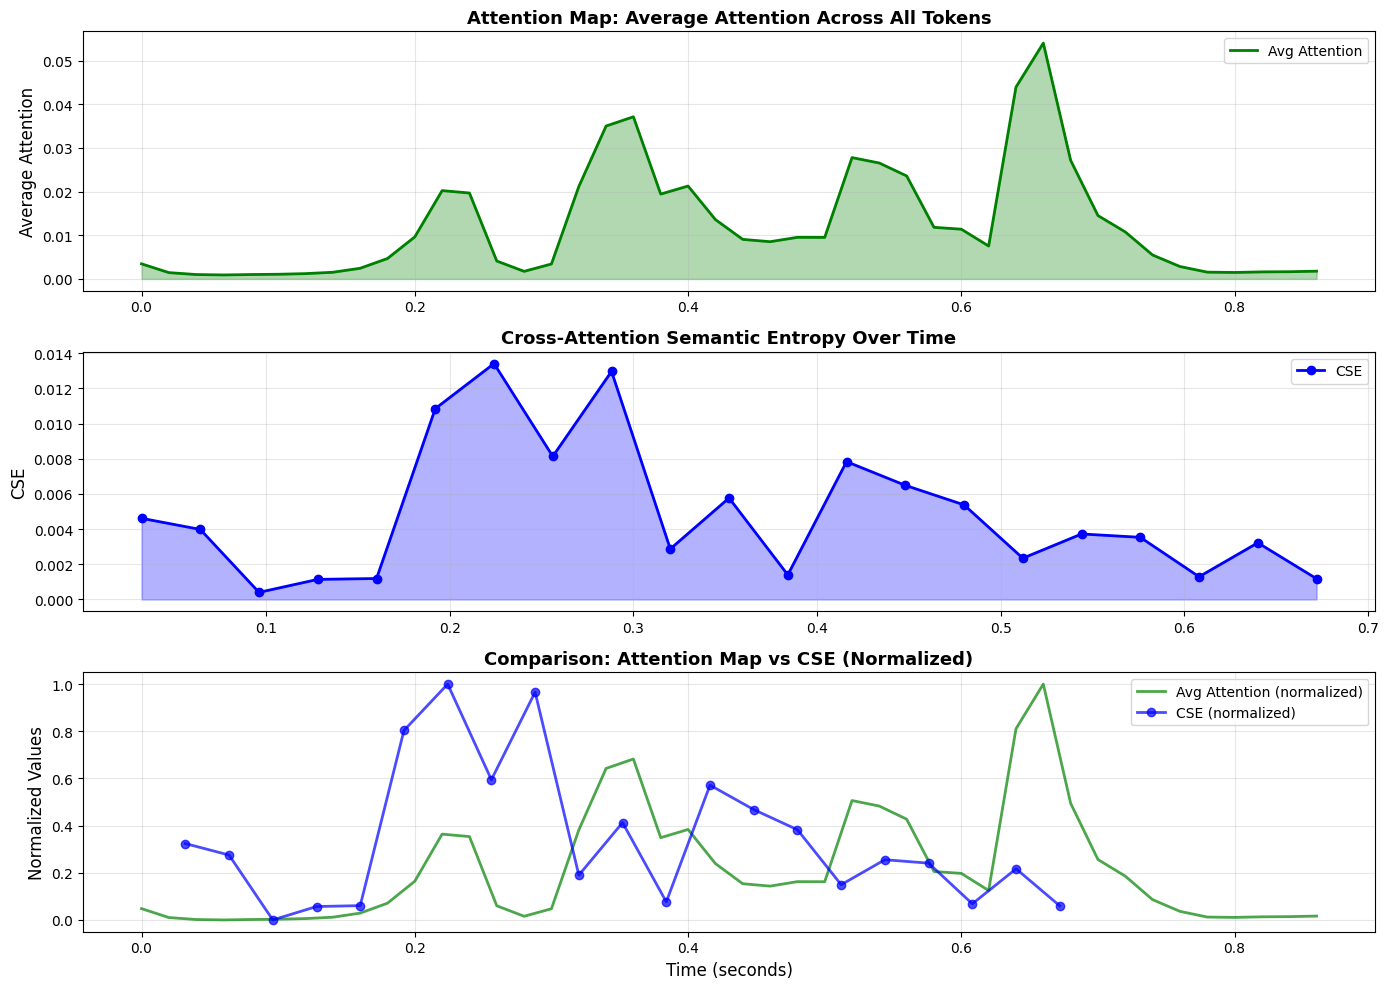


Comparison Summary:
Attention map shape: (3, 44) (tokens x frames)
Avg Attention range: [0.0009, 0.0540]
CSE range: [0.0004, 0.0134]
Time coverage - Attention: 0 to 0.88s
Time coverage - CSE: 0.0161 to 0.6881s


In [18]:
# Compare attention map with CSE data
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Attention map average across tokens
ax1 = axes[0]
avg_attention = attentions.mean(axis=0)  # Average across word tokens
time_frames = np.arange(len(avg_attention)) * 0.02  # Convert frames to seconds
ax1.plot(time_frames, avg_attention, linewidth=2, color='green', label='Avg Attention')
ax1.fill_between(time_frames, avg_attention, alpha=0.3, color='green')
ax1.set_ylabel('Average Attention', fontsize=12)
ax1.set_title('Attention Map: Average Attention Across All Tokens', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: CSE values
ax2 = axes[1]
midpoint = (df['StartTime'] + df['EndTime']) / 2
ax2.plot(midpoint, df['CSE'], marker='o', linewidth=2, markersize=6, color='blue', label='CSE')
ax2.fill_between(midpoint, df['CSE'], alpha=0.3, color='blue')
ax2.set_ylabel('CSE', fontsize=12)
ax2.set_title('Cross-Attention Semantic Entropy Over Time', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Combined comparison with normalized scales
ax3 = axes[2]
# Normalize both for easy comparison
avg_attention_norm = (avg_attention - avg_attention.min()) / (avg_attention.max() - avg_attention.min())
cse_norm = (df['CSE'].values - df['CSE'].min()) / (df['CSE'].max() - df['CSE'].min())

ax3.plot(time_frames, avg_attention_norm, linewidth=2, color='green', label='Avg Attention (normalized)', alpha=0.7)
ax3.plot(midpoint, cse_norm, marker='o', linewidth=2, color='blue', label='CSE (normalized)', alpha=0.7)
ax3.set_xlabel('Time (seconds)', fontsize=12)
ax3.set_ylabel('Normalized Values', fontsize=12)
ax3.set_title('Comparison: Attention Map vs CSE (Normalized)', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparison Summary:")
print(f"Attention map shape: {attentions.shape} (tokens x frames)")
print(f"Avg Attention range: [{avg_attention.min():.4f}, {avg_attention.max():.4f}]")
print(f"CSE range: [{df['CSE'].min():.4f}, {df['CSE'].max():.4f}]")
print(f"Time coverage - Attention: 0 to {len(avg_attention)*0.02:.2f}s")
print(f"Time coverage - CSE: {df['StartTime'].min():.4f} to {df['EndTime'].max():.4f}s")

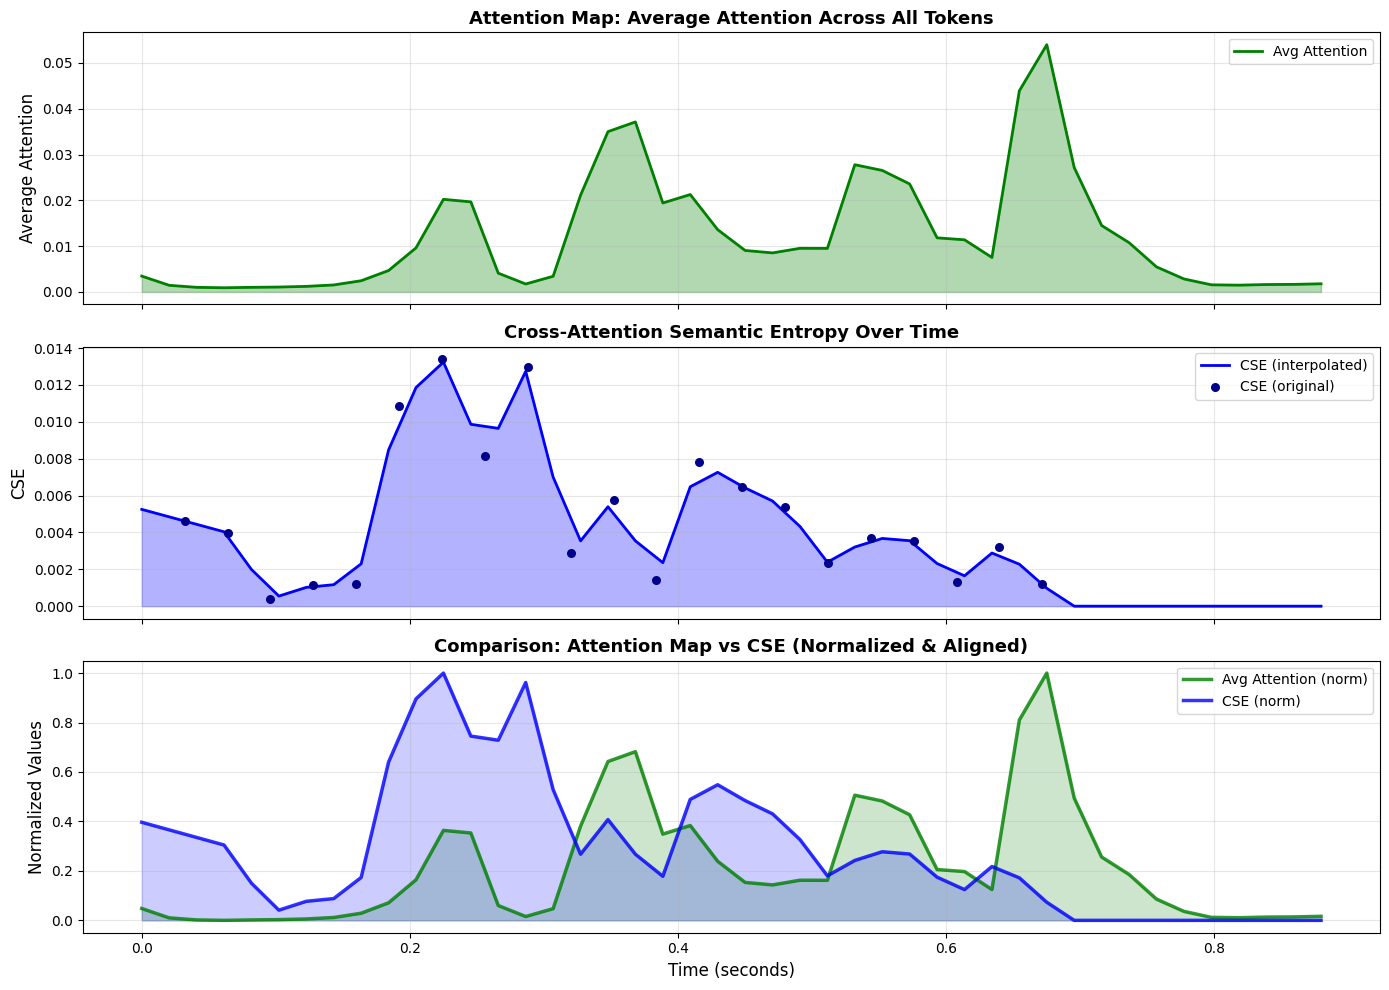


Aligned Comparison Summary:
Common time axis: 0 to 0.88s with 44 points
Attention map shape: (3, 44) (tokens x frames)
Avg Attention range: [0.0009, 0.0540]
CSE range: [0.0004, 0.0134]
CSE time coverage: 0.0161 to 0.6881s


In [19]:
# Aligned time scale comparison
from scipy.interpolate import interp1d

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Create a common time axis for all data
max_time = max(len(avg_attention) * 0.02, df['EndTime'].max())
common_time = np.linspace(0, max_time, len(avg_attention))

# Plot 1: Attention map average across tokens (aligned)
ax1 = axes[0]
ax1.plot(common_time, avg_attention, linewidth=2, color='green', label='Avg Attention')
ax1.fill_between(common_time, avg_attention, alpha=0.3, color='green')
ax1.set_ylabel('Average Attention', fontsize=12)
ax1.set_title('Attention Map: Average Attention Across All Tokens', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: CSE values - interpolated to match attention resolution
ax2 = axes[1]
# For each CSE value, map it to the midpoint of its time interval
cse_times = (df['StartTime'].values + df['EndTime'].values) / 2
cse_values = df['CSE'].values

# Interpolate CSE to match the common time axis
f_cse = interp1d(cse_times, cse_values, kind='linear', fill_value='extrapolate', bounds_error=False)
cse_interpolated = f_cse(common_time)
cse_interpolated = np.maximum(cse_interpolated, 0)  # Clamp to 0 since entropy shouldn't be negative

ax2.plot(common_time, cse_interpolated, linewidth=2, color='blue', label='CSE (interpolated)')
ax2.fill_between(common_time, cse_interpolated, alpha=0.3, color='blue')
# Overlay original CSE points
ax2.scatter(cse_times, cse_values, color='darkblue', s=30, label='CSE (original)', zorder=5)
ax2.set_ylabel('CSE', fontsize=12)
ax2.set_title('Cross-Attention Semantic Entropy Over Time', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Combined comparison with normalized scales
ax3 = axes[2]
# Normalize both for easy comparison
avg_attention_norm = (avg_attention - avg_attention.min()) / (avg_attention.max() - avg_attention.min() + 1e-8)
cse_norm = (cse_interpolated - cse_interpolated.min()) / (cse_interpolated.max() - cse_interpolated.min() + 1e-8)

ax3.plot(common_time, avg_attention_norm, linewidth=2.5, color='green', label='Avg Attention (norm)', alpha=0.8)
ax3.plot(common_time, cse_norm, linewidth=2.5, color='blue', label='CSE (norm)', alpha=0.8)
ax3.fill_between(common_time, avg_attention_norm, alpha=0.2, color='green')
ax3.fill_between(common_time, cse_norm, alpha=0.2, color='blue')
ax3.set_xlabel('Time (seconds)', fontsize=12)
ax3.set_ylabel('Normalized Values', fontsize=12)
ax3.set_title('Comparison: Attention Map vs CSE (Normalized & Aligned)', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAligned Comparison Summary:")
print(f"Common time axis: 0 to {max_time:.2f}s with {len(common_time)} points")
print(f"Attention map shape: {attentions.shape} (tokens x frames)")
print(f"Avg Attention range: [{avg_attention.min():.4f}, {avg_attention.max():.4f}]")
print(f"CSE range: [{df['CSE'].min():.4f}, {df['CSE'].max():.4f}]")
print(f"CSE time coverage: {df['StartTime'].min():.4f} to {df['EndTime'].max():.4f}s")

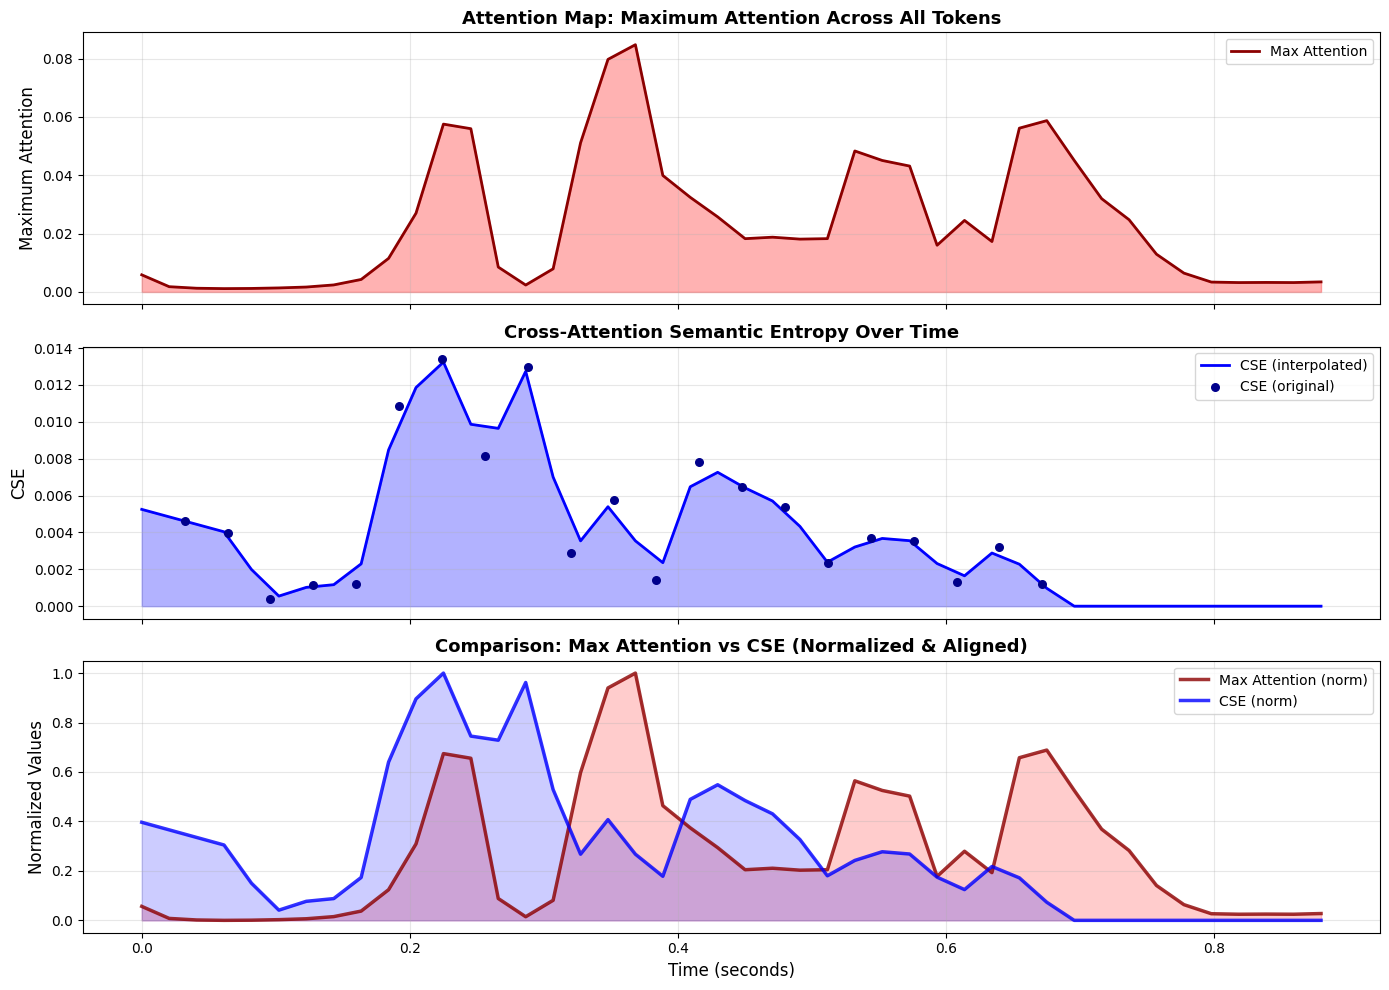


Max Attention vs CSE Comparison:
Common time axis: 0 to 0.88s with 44 points
Max Attention range: [0.0012, 0.0847]
CSE range: [0.0004, 0.0134]
Correlation (normalized): 0.1744

Peak Max Attention at: 0.37s
Peak CSE at: 0.23s


In [20]:
# Comparison using attention MAXIMUM value per frame
from scipy.interpolate import interp1d

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Create a common time axis for all data
max_time = max(len(avg_attention) * 0.02, df['EndTime'].max())
common_time = np.linspace(0, max_time, len(avg_attention))

# Compute maximum attention per frame (instead of average)
max_attention = attentions.max(axis=0)  # Maximum across word tokens

# Plot 1: Attention map MAXIMUM across tokens (aligned)
ax1 = axes[0]
ax1.plot(common_time, max_attention, linewidth=2, color='darkred', label='Max Attention')
ax1.fill_between(common_time, max_attention, alpha=0.3, color='red')
ax1.set_ylabel('Maximum Attention', fontsize=12)
ax1.set_title('Attention Map: Maximum Attention Across All Tokens', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: CSE values - interpolated to match attention resolution
ax2 = axes[1]
# For each CSE value, map it to the midpoint of its time interval
cse_times = (df['StartTime'].values + df['EndTime'].values) / 2
cse_values = df['CSE'].values

# Interpolate CSE to match the common time axis
f_cse = interp1d(cse_times, cse_values, kind='linear', fill_value='extrapolate', bounds_error=False)
cse_interpolated = f_cse(common_time)
cse_interpolated = np.maximum(cse_interpolated, 0)  # Clamp to 0

ax2.plot(common_time, cse_interpolated, linewidth=2, color='blue', label='CSE (interpolated)')
ax2.fill_between(common_time, cse_interpolated, alpha=0.3, color='blue')
# Overlay original CSE points
ax2.scatter(cse_times, cse_values, color='darkblue', s=30, label='CSE (original)', zorder=5)
ax2.set_ylabel('CSE', fontsize=12)
ax2.set_title('Cross-Attention Semantic Entropy Over Time', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Combined comparison with normalized scales (MAX vs CSE)
ax3 = axes[2]
# Normalize both for easy comparison
max_attention_norm = (max_attention - max_attention.min()) / (max_attention.max() - max_attention.min() + 1e-8)
cse_norm = (cse_interpolated - cse_interpolated.min()) / (cse_interpolated.max() - cse_interpolated.min() + 1e-8)

ax3.plot(common_time, max_attention_norm, linewidth=2.5, color='darkred', label='Max Attention (norm)', alpha=0.8)
ax3.plot(common_time, cse_norm, linewidth=2.5, color='blue', label='CSE (norm)', alpha=0.8)
ax3.fill_between(common_time, max_attention_norm, alpha=0.2, color='red')
ax3.fill_between(common_time, cse_norm, alpha=0.2, color='blue')
ax3.set_xlabel('Time (seconds)', fontsize=12)
ax3.set_ylabel('Normalized Values', fontsize=12)
ax3.set_title('Comparison: Max Attention vs CSE (Normalized & Aligned)', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute correlation between max attention and CSE
correlation = np.corrcoef(max_attention_norm, cse_norm)[0, 1]

print("\nMax Attention vs CSE Comparison:")
print(f"Common time axis: 0 to {max_time:.2f}s with {len(common_time)} points")
print(f"Max Attention range: [{max_attention.min():.4f}, {max_attention.max():.4f}]")
print(f"CSE range: [{df['CSE'].min():.4f}, {df['CSE'].max():.4f}]")
print(f"Correlation (normalized): {correlation:.4f}")
print(f"\nPeak Max Attention at: {common_time[np.argmax(max_attention)]:.2f}s")
print(f"Peak CSE at: {common_time[np.argmax(cse_norm)]:.2f}s")